**Using PCA**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load and preprocess df1
df1 = pd.read_excel('EOGsignal.xlsx').iloc[:, 1:]
df1.columns = ['f' + str(i) for i in range(0, 24)] + ['class']
X1 = df1.drop(['class'], axis=1)
y1 = df1['class']

# Load and preprocess df2
df2 = pd.read_csv('EMGF1.csv')
df2 = df2.drop(columns=['time'])
df2.columns = ['f' + str(i) for i in range(0, 8)] + ['class']

# Filter df2 to include only classes present in df1
valid_classes = df1['class'].unique()
df2 = df2[df2['class'].isin(valid_classes)]

X2 = df2.drop(['class'], axis=1)
y2 = df2['class']

# Apply PCA for df1
pca = PCA(n_components=5, random_state=23)
X1_pca = pca.fit_transform(X1)

# Apply PCA for df2
X2_pca = pca.fit_transform(X2)

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
X1_scaled = scaler.fit_transform(X1_pca)
X2_scaled = scaler.fit_transform(X2_pca)

# Split data into training and testing sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_scaled, y1, test_size=0.1, random_state=23)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_scaled, y2, test_size=0.1, random_state=23)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X1_train_resampled, y1_train_resampled = smote.fit_resample(X1_train, y1_train)
X2_train_resampled, y2_train_resampled = smote.fit_resample(X2_train, y2_train)


In [2]:
# Define classifiers
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

# Create and train ensemble models for df1
voting_clf_df1 = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier())
    ],
    voting='hard'  # Use soft voting
)
voting_clf_df1.fit(X1_train_resampled, y1_train_resampled)

# Create and train ensemble models for df2
voting_clf_df2 = VotingClassifier(
    estimators=[
        ('dt', DecisionTreeClassifier()),
        ('rf', RandomForestClassifier()),
        ('knn', KNeighborsClassifier())
    ],
    voting='hard'  # Use hard / soft voting
)
voting_clf_df2.fit(X2_train_resampled, y2_train_resampled)

# Get predictions from the df1 and df2 ensemble models on test data
df1_test_predictions = voting_clf_df1.predict(X1_test)
df2_test_predictions = voting_clf_df2.predict(X2_test)

# Ensure equal number of samples in both datasets
min_samples = min(len(X1_train_resampled), len(X2_train_resampled))

X1_train_resampled, y1_train_resampled = X1_train_resampled[:min_samples], y1_train_resampled[:min_samples]
X2_train_resampled, y2_train_resampled = X2_train_resampled[:min_samples], y2_train_resampled[:min_samples]

# Combine predictions from the training data for stacking
X_combined_train = pd.DataFrame({
    'df1': voting_clf_df1.predict(X1_train_resampled),
    'df2': voting_clf_df2.predict(X2_train_resampled)
})

# Training labels for the stacking model
y_combined_train = y1_train_resampled  # Use the labels from df1 as reference


# Define the base models for stacking
estimators = [
    ('voting_df1', voting_clf_df1),
    ('voting_df2', voting_clf_df2)
]

# Create and train the StackingClassifier
stacked_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=RandomForestClassifier()  # You can choose any other classifier as the final estimator
)

stacked_clf.fit(X_combined_train, y_combined_train)


StackingClassifier(estimators=[('voting_df1',
                                VotingClassifier(estimators=[('dt',
                                                              DecisionTreeClassifier()),
                                                             ('rf',
                                                              RandomForestClassifier()),
                                                             ('knn',
                                                              KNeighborsClassifier())])),
                               ('voting_df2',
                                VotingClassifier(estimators=[('dt',
                                                              DecisionTreeClassifier()),
                                                             ('rf',
                                                              RandomForestClassifier()),
                                                             ('knn',
                                                              KNeighborsClassifier())]))],
                   final_estimator=RandomForestClassifier())

**Evaluating the EOG**

Performance of individual classifiers for EOG:

Classifier: Decision Tree
Accuracy: 0.7341
F1 Score: 0.7364
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67        63
           1       0.69      0.66      0.68        76
           2       0.80      0.80      0.80        79
           3       0.50      0.55      0.52        55
           4       0.97      0.93      0.95        73

    accuracy                           0.73       346
   macro avg       0.72      0.72      0.72       346
weighted avg       0.74      0.73      0.74       346



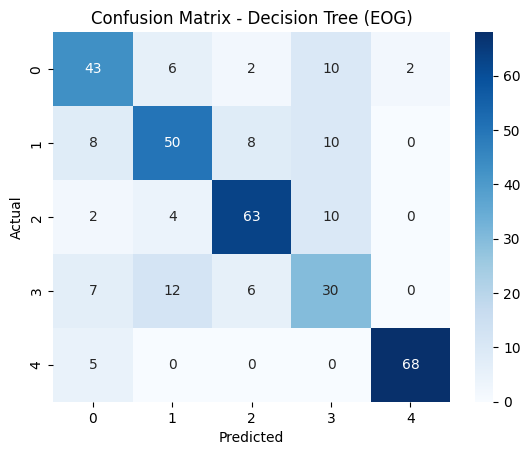


Classifier: Random Forest
Accuracy: 0.8584
F1 Score: 0.8597
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85        63
           1       0.86      0.79      0.82        76
           2       0.88      0.89      0.88        79
           3       0.68      0.78      0.73        55
           4       0.99      0.97      0.98        73

    accuracy                           0.86       346
   macro avg       0.85      0.85      0.85       346
weighted avg       0.86      0.86      0.86       346



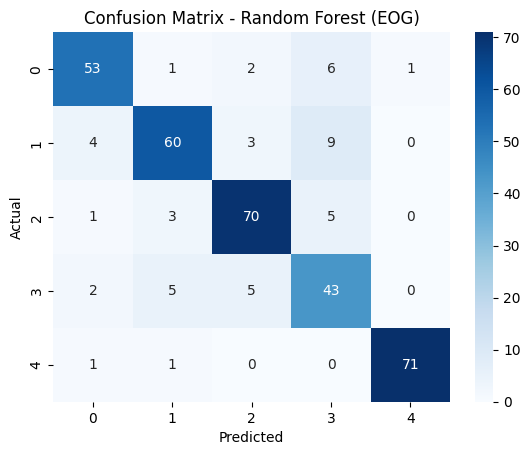


Classifier: KNN
Accuracy: 0.8497
F1 Score: 0.8507
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        63
           1       0.82      0.80      0.81        76
           2       0.86      0.89      0.88        79
           3       0.65      0.71      0.68        55
           4       1.00      1.00      1.00        73

    accuracy                           0.85       346
   macro avg       0.84      0.84      0.84       346
weighted avg       0.85      0.85      0.85       346



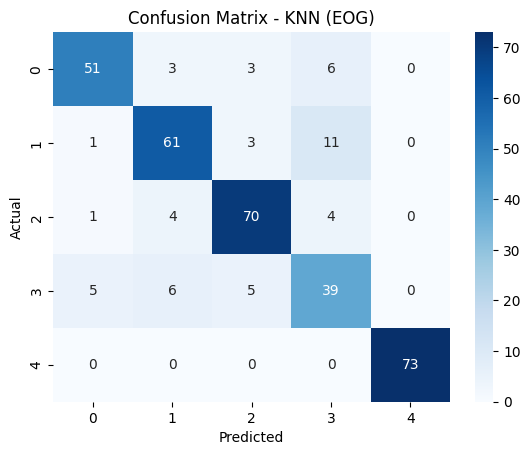


Performance of ensemble model (Voting Classifier) for EOG:
Accuracy: 0.8497
F1 Score: 0.8503
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        63
           1       0.83      0.78      0.80        76
           2       0.90      0.89      0.89        79
           3       0.66      0.69      0.67        55
           4       1.00      1.00      1.00        73

    accuracy                           0.85       346
   macro avg       0.84      0.84      0.84       346
weighted avg       0.85      0.85      0.85       346



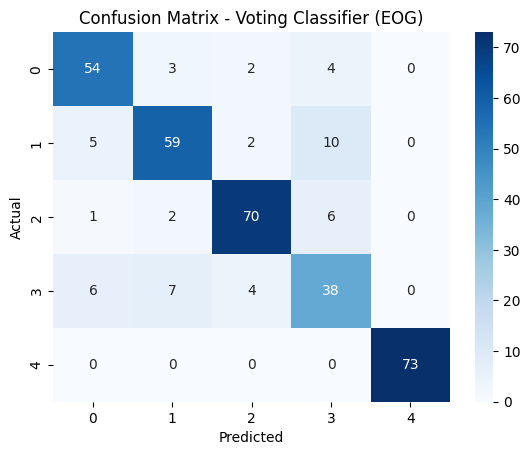

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Evaluate individual classifiers for df1
print("Performance of individual classifiers for EOG:")
for name, clf in classifiers.items():
    clf.fit(X1_train_resampled, y1_train_resampled)
    y_pred = clf.predict(X1_test)
    
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {accuracy_score(y1_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y1_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y1_test, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y1_test, y_pred, f'Confusion Matrix - {name} (EOG)')

# Evaluate the ensemble model for df1
print("\nPerformance of ensemble model (Voting Classifier) for EOG:")
y_pred_df1_ensemble = voting_clf_df1.predict(X1_test)
print(f"Accuracy: {accuracy_score(y1_test, y_pred_df1_ensemble):.4f}")
print(f"F1 Score: {f1_score(y1_test, y_pred_df1_ensemble, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y1_test, y_pred_df1_ensemble))

# Plot confusion matrix for ensemble model
plot_confusion_matrix(y1_test, y_pred_df1_ensemble, 'Confusion Matrix - Voting Classifier (EOG)')


**Evaluating the EMG**

Performance of individual classifiers for EMG:

Classifier: Decision Tree
Accuracy: 0.8426
F1 Score: 0.8431
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3988
           1       0.62      0.59      0.60       381
           2       0.69      0.65      0.67       332
           3       0.70      0.80      0.75       292
           4       0.64      0.74      0.68       285

    accuracy                           0.84      5278
   macro avg       0.71      0.73      0.72      5278
weighted avg       0.84      0.84      0.84      5278



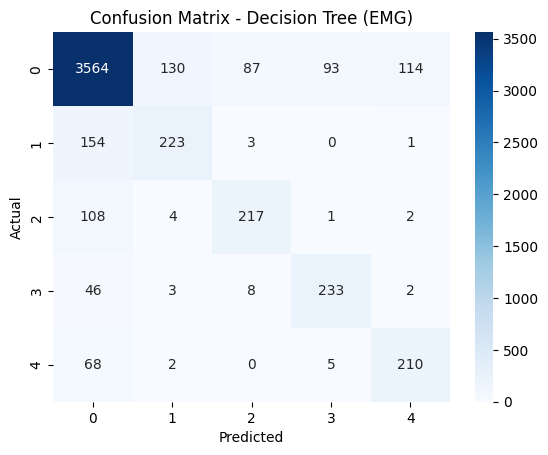


Classifier: Random Forest
Accuracy: 0.8954
F1 Score: 0.8874
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3988
           1       0.90      0.53      0.67       381
           2       0.96      0.61      0.74       332
           3       0.90      0.74      0.81       292
           4       0.93      0.66      0.77       285

    accuracy                           0.90      5278
   macro avg       0.91      0.70      0.79      5278
weighted avg       0.90      0.90      0.89      5278



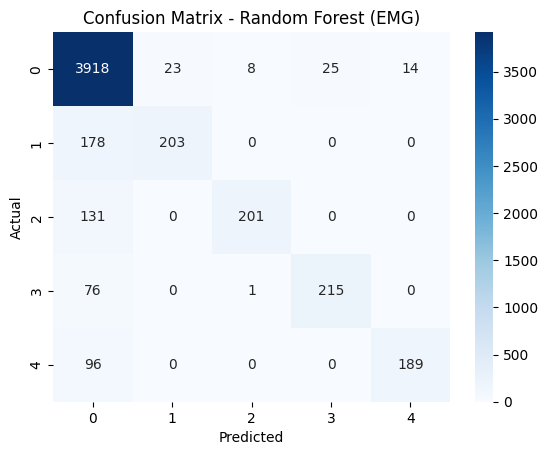


Classifier: KNN
Accuracy: 0.7503
F1 Score: 0.7284
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85      3988
           1       0.46      0.25      0.33       381
           2       0.43      0.29      0.35       332
           3       0.49      0.45      0.47       292
           4       0.47      0.24      0.31       285

    accuracy                           0.75      5278
   macro avg       0.53      0.42      0.46      5278
weighted avg       0.72      0.75      0.73      5278



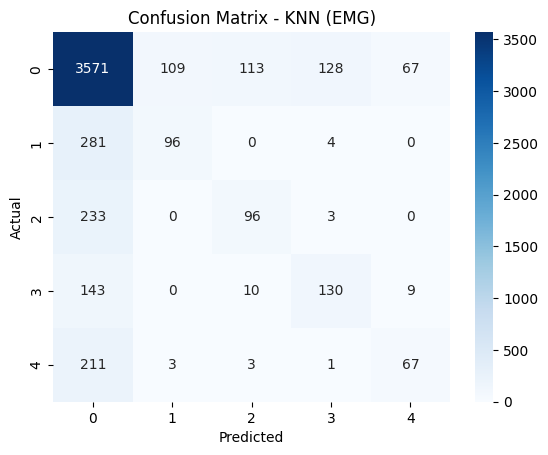


Performance of ensemble model (Voting Classifier) for EMG:
Accuracy: 0.8958
F1 Score: 0.8886
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3988
           1       0.89      0.55      0.68       381
           2       0.91      0.61      0.73       332
           3       0.86      0.78      0.82       292
           4       0.94      0.66      0.78       285

    accuracy                           0.90      5278
   macro avg       0.90      0.72      0.79      5278
weighted avg       0.90      0.90      0.89      5278



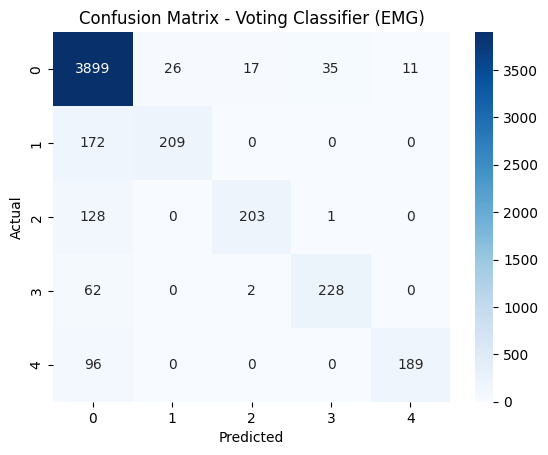

In [11]:
# Evaluate individual classifiers for df2
print("Performance of individual classifiers for EMG:")
for name, clf in classifiers.items():
    clf.fit(X2_train_resampled, y2_train_resampled)
    y_pred = clf.predict(X2_test)
    
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {accuracy_score(y2_test, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y2_test, y_pred, average='weighted'):.4f}")
    print("Classification Report:")
    print(classification_report(y2_test, y_pred))
    
    # Plot confusion matrix
    plot_confusion_matrix(y2_test, y_pred, f'Confusion Matrix - {name} (EMG)')

# Evaluate the ensemble model for df2
print("\nPerformance of ensemble model (Voting Classifier) for EMG:")
y_pred_df2_ensemble = voting_clf_df2.predict(X2_test)
print(f"Accuracy: {accuracy_score(y2_test, y_pred_df2_ensemble):.4f}")
print(f"F1 Score: {f1_score(y2_test, y_pred_df2_ensemble, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y2_test, y_pred_df2_ensemble))

# Plot confusion matrix for ensemble model
plot_confusion_matrix(y2_test, y_pred_df2_ensemble, 'Confusion Matrix - Voting Classifier (EMG)')


**Evaluating the Ensemble model of EOG and EMG**

In [12]:
# Ensure both predictions have the same length
min_len = min(len(df1_test_predictions), len(df2_test_predictions))
df1_test_predictions = df1_test_predictions[:min_len]
df2_test_predictions = df2_test_predictions[:min_len]
y1_test = y1_test[:min_len]

# Combine predictions from the test data for evaluation
X_combined_test = pd.DataFrame({
    'df1': df1_test_predictions,
    'df2': df2_test_predictions
})

# Get predictions from the stacking classifier
y_combined_pred = stacked_clf.predict(X_combined_test)

# Evaluate the combined model
accuracy = accuracy_score(y1_test, y_combined_pred)
f1 = f1_score(y1_test, y_combined_pred, average='weighted')
precision = precision_score(y1_test, y_combined_pred, average='weighted')
recall = recall_score(y1_test, y_combined_pred, average='weighted')

print("Stacking Model Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("Classification Report:")
print(classification_report(y1_test, y_combined_pred))
print("Confusion Matrix:")
print(confusion_matrix(y1_test, y_combined_pred))


Stacking Model Results:
Accuracy: 0.8497
F1 Score: 0.8503
Precision: 0.8515
Recall: 0.8497
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84        63
           1       0.83      0.78      0.80        76
           2       0.90      0.89      0.89        79
           3       0.66      0.69      0.67        55
           4       1.00      1.00      1.00        73

    accuracy                           0.85       346
   macro avg       0.84      0.84      0.84       346
weighted avg       0.85      0.85      0.85       346

Confusion Matrix:
[[54  3  2  4  0]
 [ 5 59  2 10  0]
 [ 1  2 70  6  0]
 [ 6  7  4 38  0]
 [ 0  0  0  0 73]]


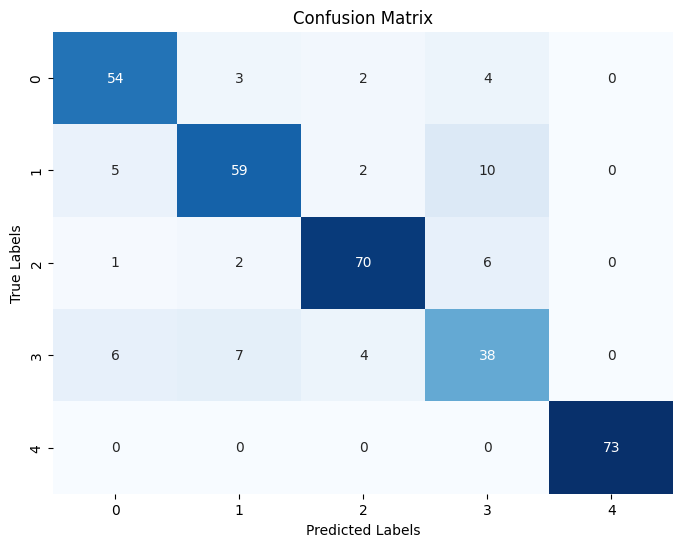

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y1_test, y_combined_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
